In [2]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

from sqlalchemy import create_engine

import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")
%matplotlib inline

In [3]:
#create and connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')

In [4]:
raw_data = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
raw_data

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290000,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460000,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20180,2022-01-07T20:32:10.944Z,60.011100,-148.479300,10.30,2.00,ml,NaN,NaN,NaN,0.3000,...,2022-02-01T23:02:58.793Z,"26 km WSW of Chenega, Alaska",earthquake,NaN,0.50,NaN,NaN,reviewed,ak,ak
20181,2022-01-07T20:30:37.581Z,57.714600,-155.765500,3.60,1.10,ml,NaN,NaN,NaN,0.5700,...,2022-02-01T23:02:58.585Z,"79 km W of Karluk, Alaska",earthquake,NaN,0.60,NaN,NaN,reviewed,ak,ak
20182,2022-01-07T20:29:18.910Z,38.826167,-122.805667,1.33,0.46,md,20.0,42.00,0.004417,0.0200,...,2022-01-12T08:32:10.153Z,"7km NW of The Geysers, CA",earthquake,0.16,0.41,0.053000,3.0,reviewed,nc,nc
20183,2022-01-07T20:24:43.614Z,64.980500,-147.361200,0.00,1.20,ml,NaN,NaN,NaN,0.2500,...,2022-02-01T23:02:59.043Z,"12 km ENE of Fox, Alaska",explosion,NaN,0.00,NaN,NaN,reviewed,ak,ak


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20185 entries, 0 to 20184
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             20185 non-null  object 
 1   latitude         20185 non-null  float64
 2   longitude        20185 non-null  float64
 3   depth            20185 non-null  float64
 4   mag              20180 non-null  float64
 5   magType          20180 non-null  object 
 6   nst              14149 non-null  float64
 7   gap              16840 non-null  float64
 8   dmin             13971 non-null  float64
 9   rms              20184 non-null  float64
 10  net              20185 non-null  object 
 11  id               20185 non-null  object 
 12  updated          20185 non-null  object 
 13  place            20185 non-null  object 
 14  type             20185 non-null  object 
 15  horizontalError  14895 non-null  float64
 16  depthError       20185 non-null  float64
 17  magError    

In [6]:
#describe numerical data
descr_table=raw_data.describe()
descr_table

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,20185.000000,20185.000000,20185.000000,20180.000000,14149.000000,16840.000000,13971.000000,20184.000000,14895.000000,20185.000000,15847.000000,16821.000000
mean,36.404868,-108.781447,22.853407,1.726416,20.488444,121.256412,0.714681,0.282825,1.898991,3.614683,0.288254,14.770109
std,19.838951,71.387189,52.951188,1.282050,15.480622,65.737282,2.251015,0.298190,3.259437,105.369952,0.552207,27.498336
min,-65.361900,-179.998500,-10.000000,-1.310000,2.000000,10.000000,0.000000,0.000000,0.090000,0.000000,0.000000,0.000000
25%,33.376667,-150.031100,3.420000,0.860000,9.000000,72.000000,0.021765,0.090000,0.290000,0.490000,0.104000,4.000000
50%,38.174100,-121.252667,8.820000,1.490000,16.000000,107.000000,0.066900,0.150000,0.490000,0.800000,0.160000,8.000000
75%,45.729500,-116.243700,18.600000,2.170000,27.000000,155.000000,0.204700,0.420000,1.150000,1.800000,0.242000,16.000000
max,85.309300,179.990100,653.870000,7.300000,189.000000,359.000000,39.750000,7.060000,54.500000,11327.700000,5.500000,619.000000


In [21]:
result1=descr_table.to_html()
print(result1)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>latitude</th>
      <th>longitude</th>
      <th>depth</th>
      <th>mag</th>
      <th>nst</th>
      <th>gap</th>
      <th>dmin</th>
      <th>rms</th>
      <th>horizontalError</th>
      <th>depthError</th>
      <th>magError</th>
      <th>magNst</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>20185.000000</td>
      <td>20185.000000</td>
      <td>20185.000000</td>
      <td>20180.000000</td>
      <td>14149.000000</td>
      <td>16840.000000</td>
      <td>13971.000000</td>
      <td>20184.000000</td>
      <td>14895.000000</td>
      <td>20185.000000</td>
      <td>15847.000000</td>
      <td>16821.000000</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>36.404868</td>
      <td>-108.781447</td>
      <td>22.853407</td>
      <td>1.726416</td>
      <td>20.488444</td>
      <td>121.256412</td>
      <td>0.714681</td>
      <td>0.282825</

In [7]:
#describe categorical data
raw_data['type'].value_counts()

earthquake           19849
quarry blast           211
explosion               85
ice quake               27
other event             11
sonic boom               1
volcanic eruption        1
Name: type, dtype: int64

In [8]:
raw_data['place'].value_counts()

Rat Islands, Aleutian Islands, Alaska    247
8km NW of The Geysers, CA                236
7km NW of The Geysers, CA                169
off the coast of Oregon                  158
6km NW of The Geysers, CA                143
                                        ... 
50 km NNW of Sola, Vanuatu                 1
42 km ESE of Barkhan, Pakistan             1
9 km ESE of Clear, Alaska, Alaska          1
99 km SW of Atocha, Bolivia                1
12 km ENE of Fox, Alaska                   1
Name: place, Length: 9366, dtype: int64

In [9]:
raw_data['magType'].value_counts()

ml       11427
md        6389
mb        2022
mww        216
mb_lg       48
mwr         40
mw          20
mh          14
mlg          1
mlr          1
mwb          1
ms_20        1
Name: magType, dtype: int64

In [10]:
raw_data['id'].value_counts()

nn00831163      1
nn00832533      1
pr2022026004    1
ak02217a6huy    1
hv72890712      1
               ..
us6000gcsr      1
ak021fwi8p4b    1
us6000gct0      1
us6000gbpq      1
hv72861177      1
Name: id, Length: 20185, dtype: int64

In [11]:
raw_data['locationSource'].value_counts()

nc    3850
ak    3343
ci    3245
us    2692
hv    1905
nn    1522
av     758
uu     642
pr     537
mb     453
ok     432
uw     420
tx     295
nm      55
se      36
Name: locationSource, dtype: int64

In [12]:
raw_data['magSource'].value_counts()

nc     3850
ak     3344
ci     3245
us     2681
hv     1905
nn     1522
av      758
uu      642
pr      537
mb      453
ok      431
uw      420
tx      295
nm       55
se       36
guc      11
Name: magSource, dtype: int64

In [13]:
corr_df = raw_data.corr()
corr_df

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
latitude,1.000000,-0.326687,-0.218526,-0.496631,-0.385262,0.125738,-0.549336,-0.042864,-0.548122,0.009306,-0.091707,-0.170144
longitude,-0.326687,1.000000,0.117386,0.494524,-0.157635,0.056339,0.350336,0.252689,0.505936,0.000148,-0.166855,0.181085
depth,-0.218526,0.117386,1.000000,0.359379,0.338547,-0.034297,0.249322,0.319531,0.496216,0.004540,0.013896,0.214986
mag,-0.496631,0.494524,0.359379,1.000000,0.460747,-0.039071,0.551048,0.620458,0.757350,-0.001587,-0.007487,0.454147
nst,-0.385262,-0.157635,0.338547,0.460747,1.000000,-0.405432,-0.068024,0.276506,-0.206315,-0.050483,0.213294,0.621496
gap,0.125738,0.056339,-0.034297,-0.039071,-0.405432,1.000000,-0.022965,-0.056463,0.104876,0.064895,0.050582,-0.155844
dmin,-0.549336,0.350336,0.249322,0.551048,-0.068024,-0.022965,1.000000,0.507736,0.658354,0.018222,-0.133993,0.231360
rms,-0.042864,0.252689,0.319531,0.620458,0.276506,-0.056463,0.507736,1.000000,0.775708,0.003614,-0.118278,0.419514
horizontalError,-0.548122,0.505936,0.496216,0.757350,-0.206315,0.104876,0.658354,0.775708,1.000000,0.235115,-0.116301,0.321869
depthError,0.009306,0.000148,0.004540,-0.001587,-0.050483,0.064895,0.018222,0.003614,0.235115,1.000000,-0.021368,0.007885


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



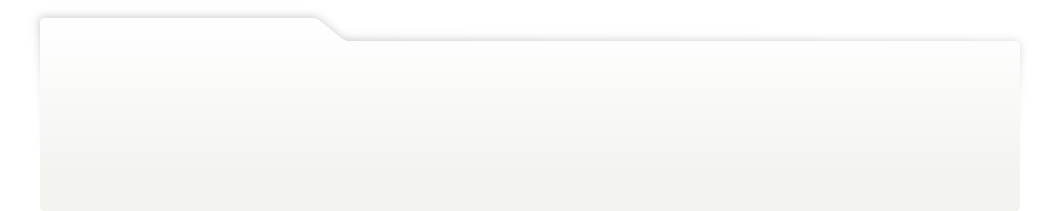
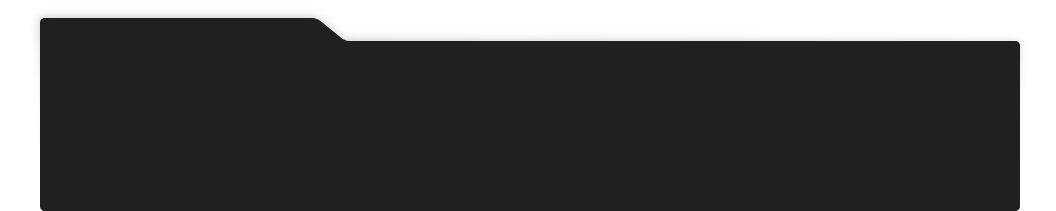
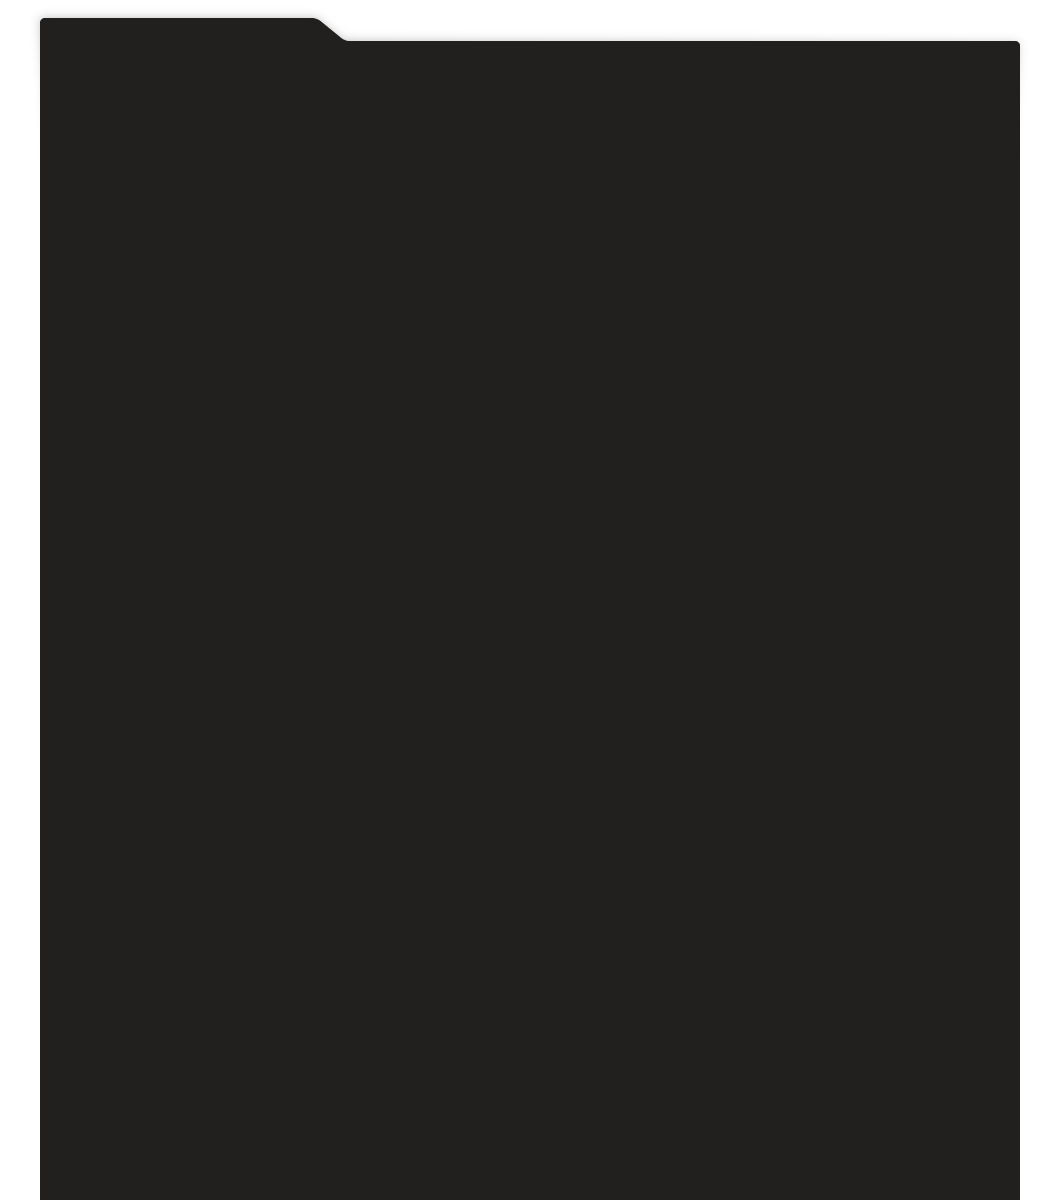
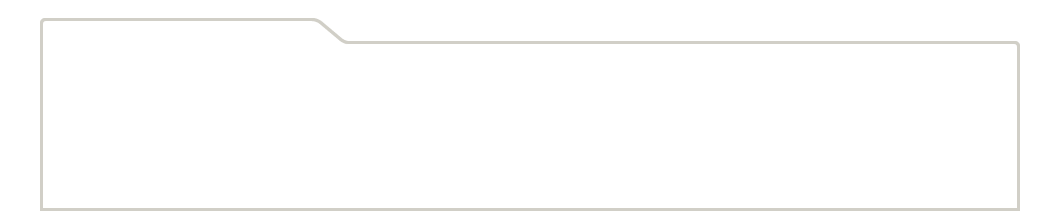
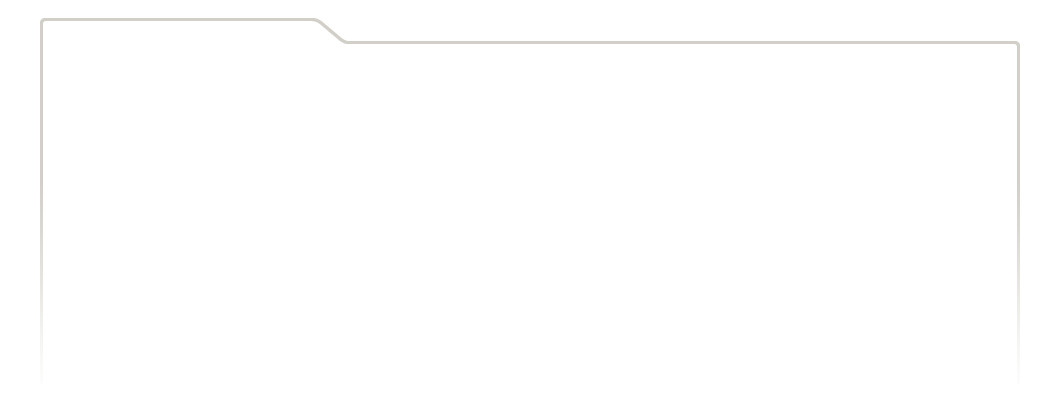
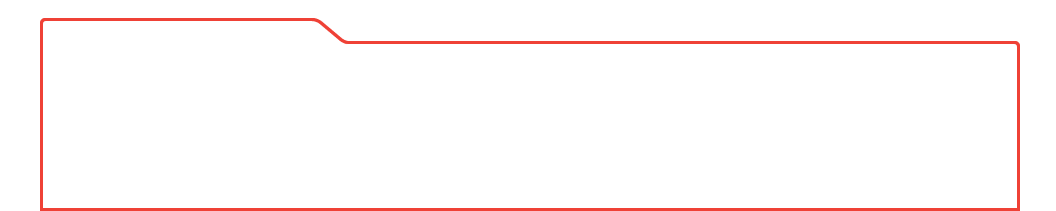
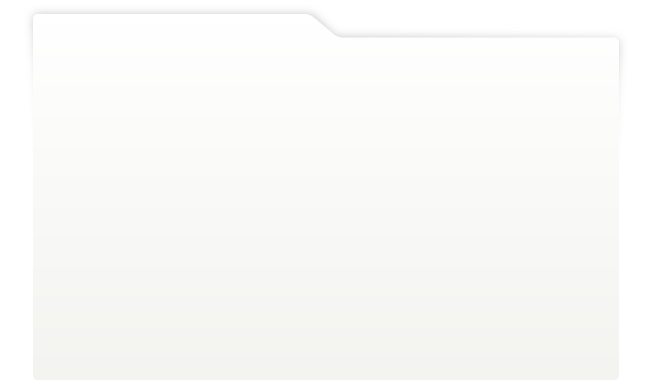
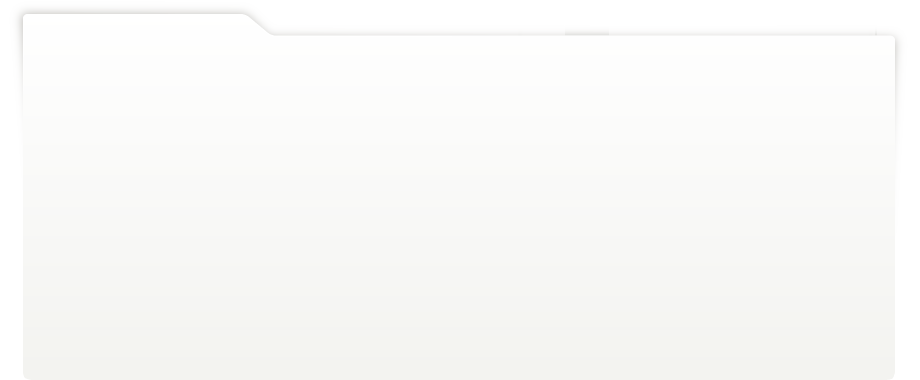
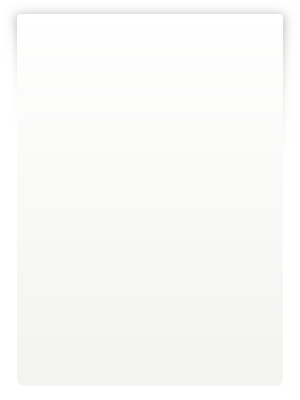
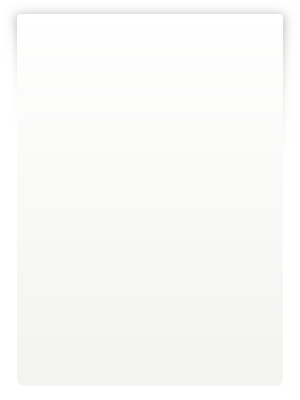
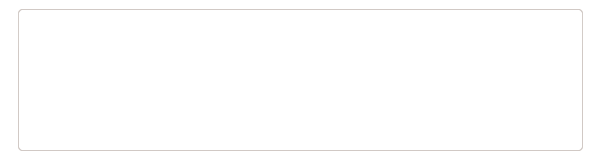
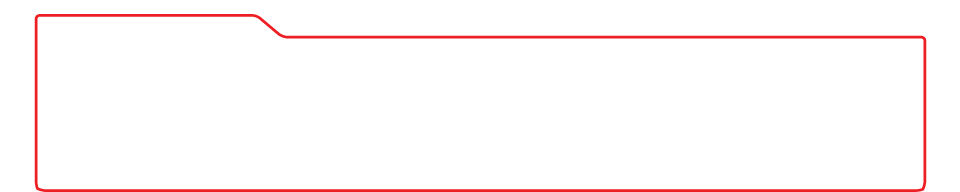
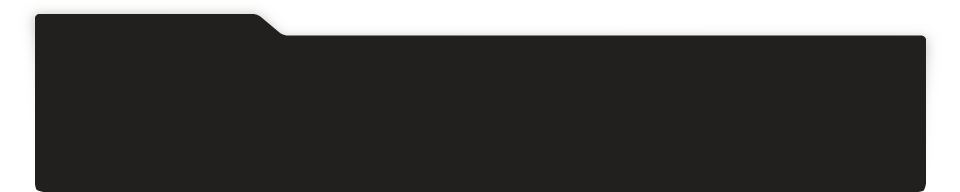
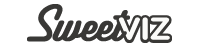
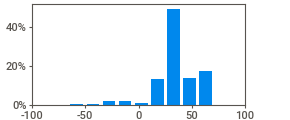
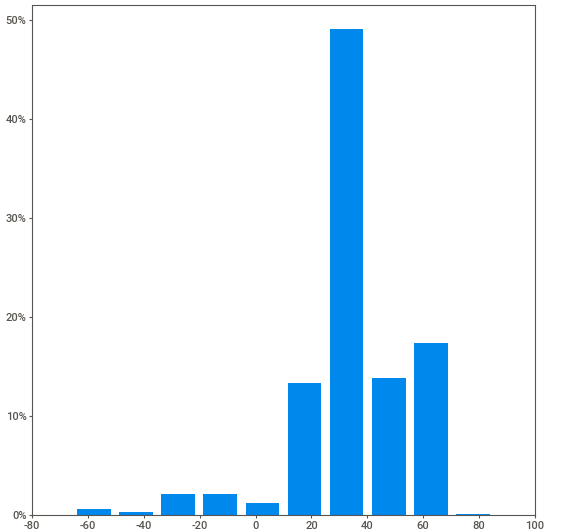
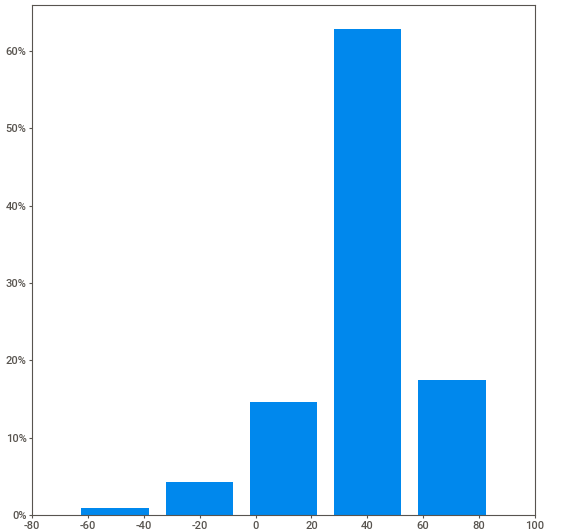
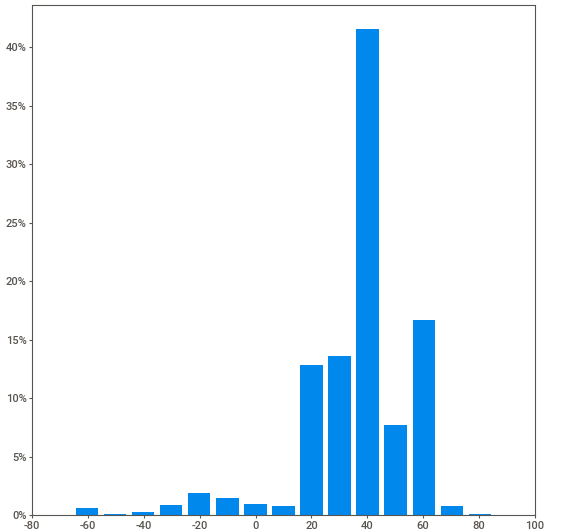
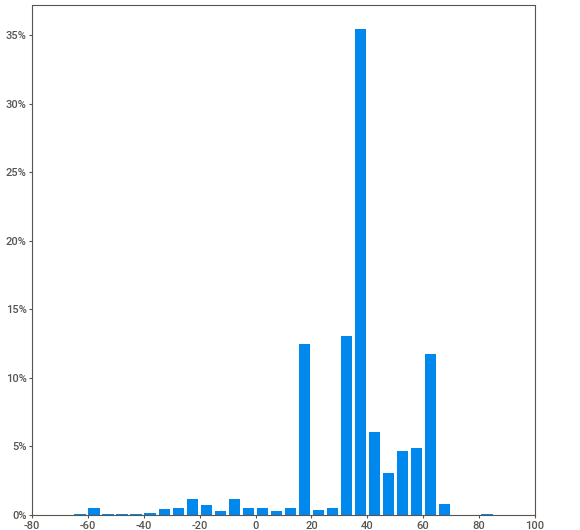
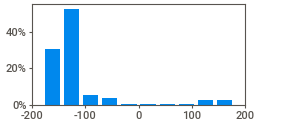
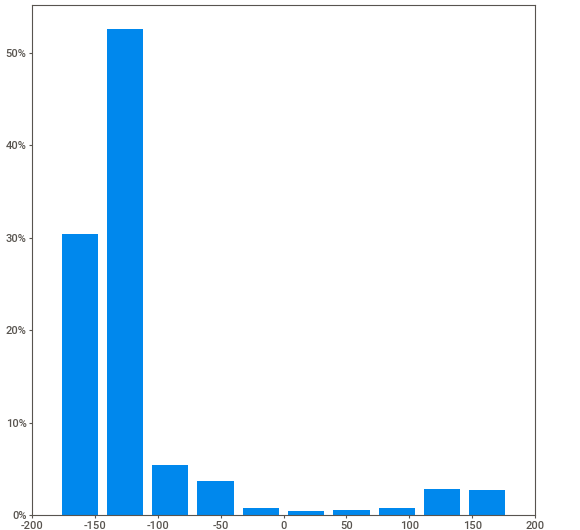
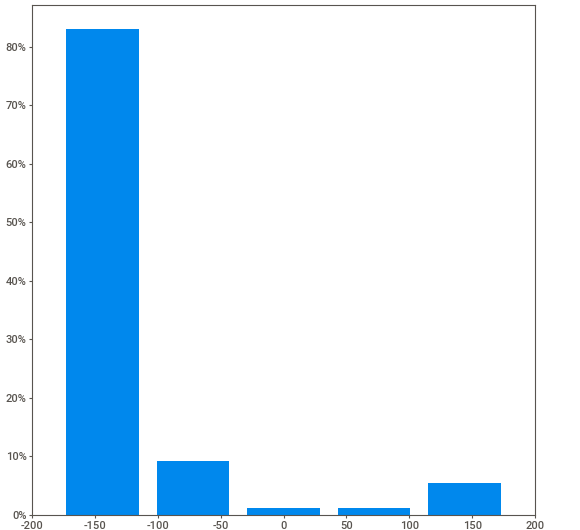
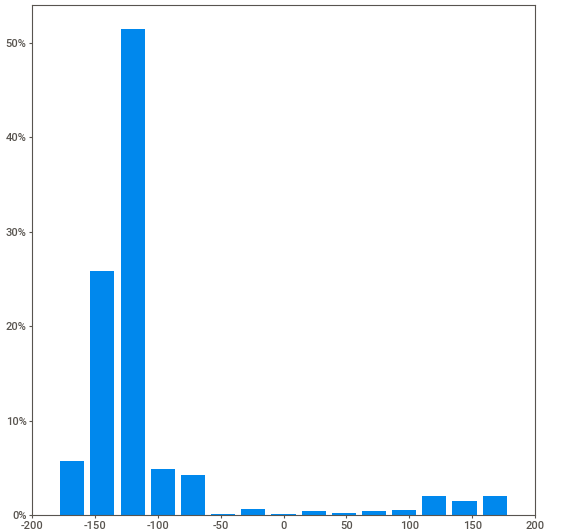
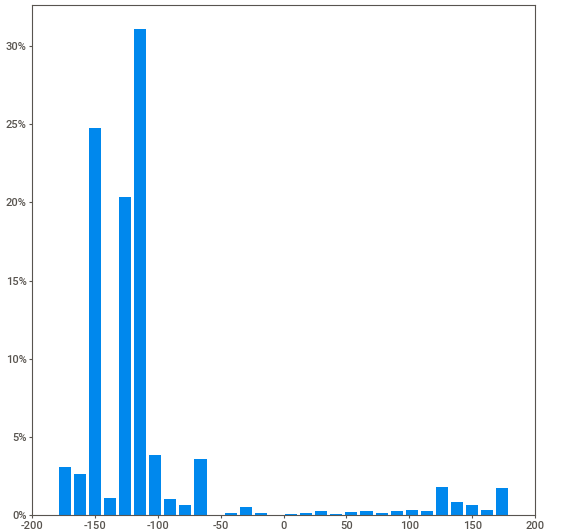
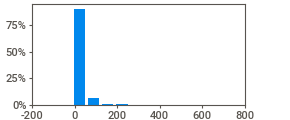
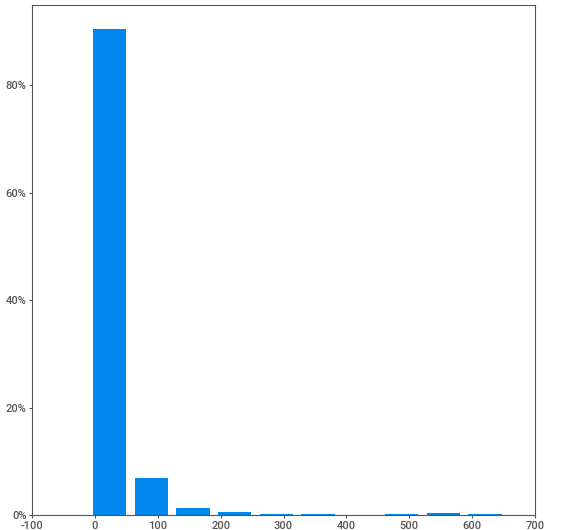
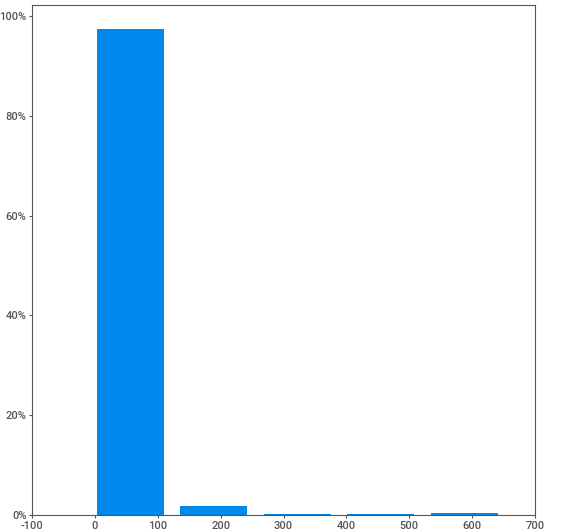
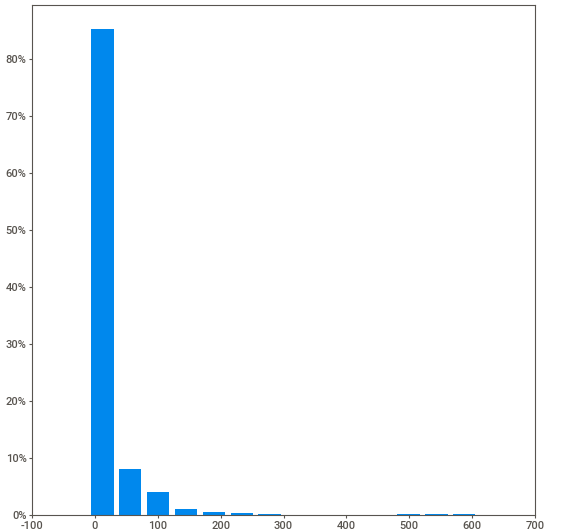
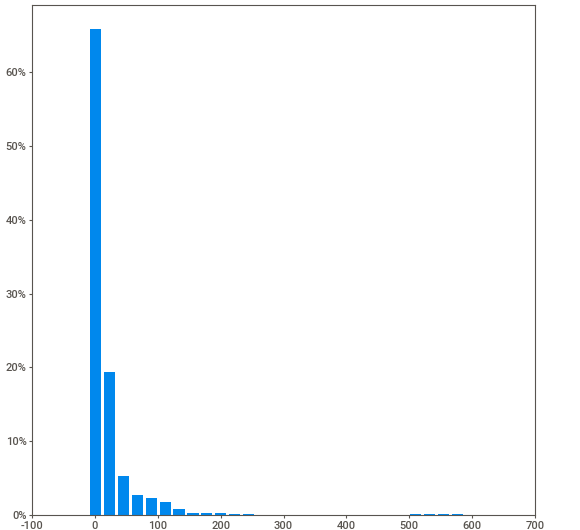
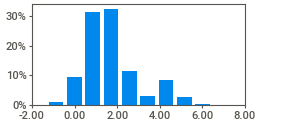
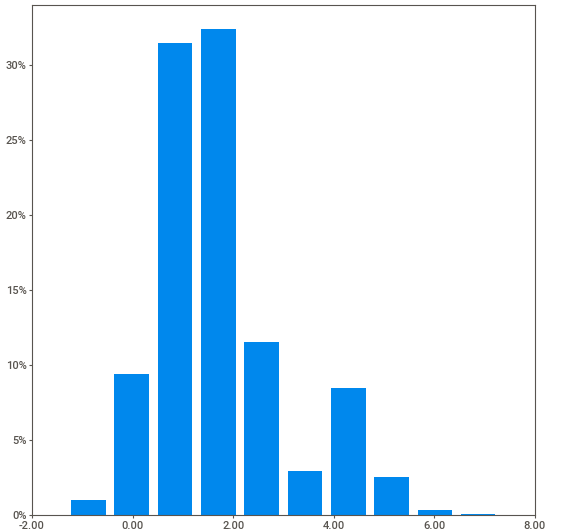
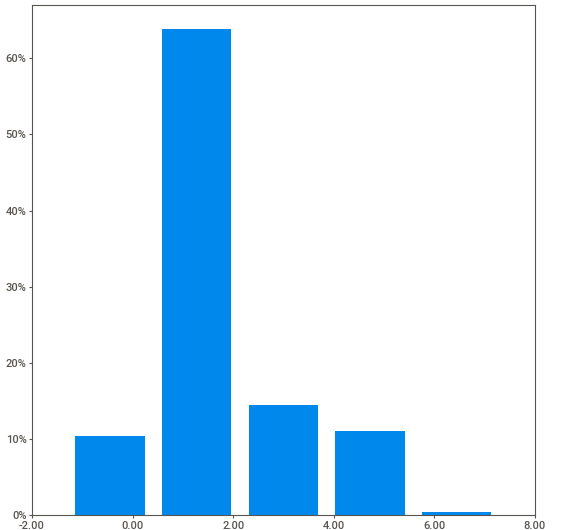
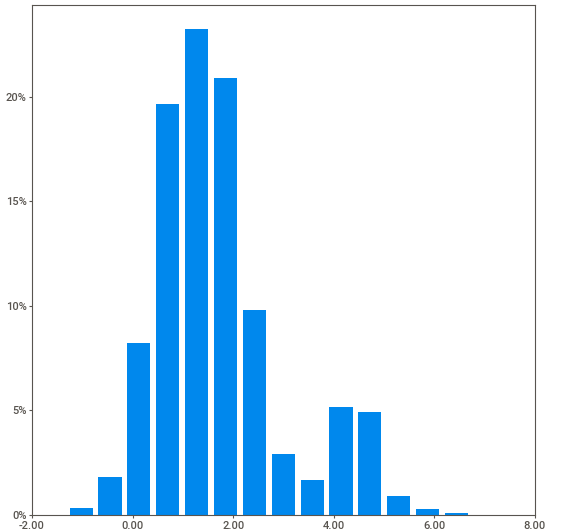
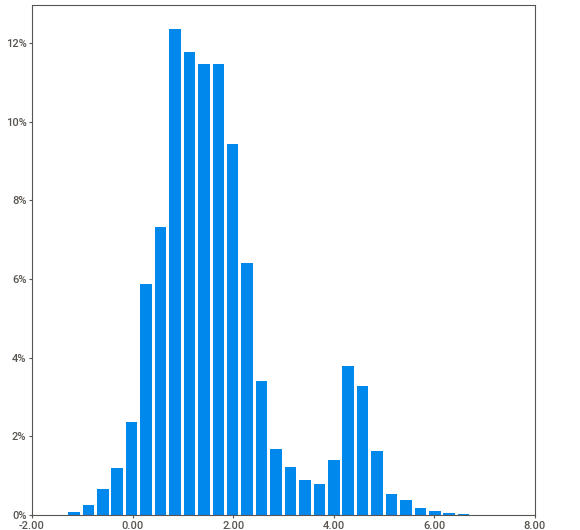
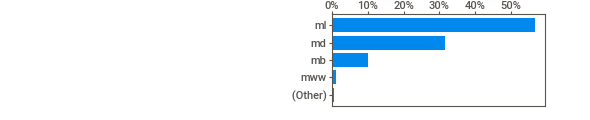
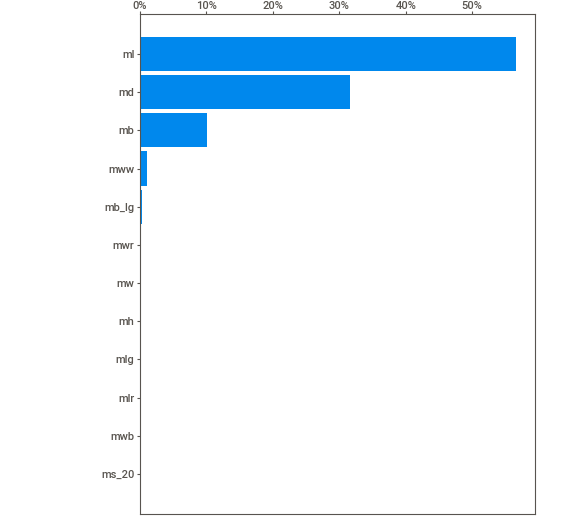
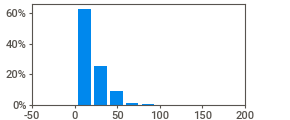
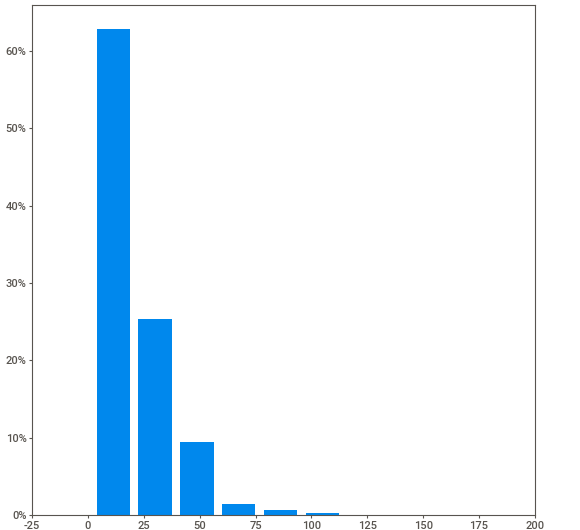
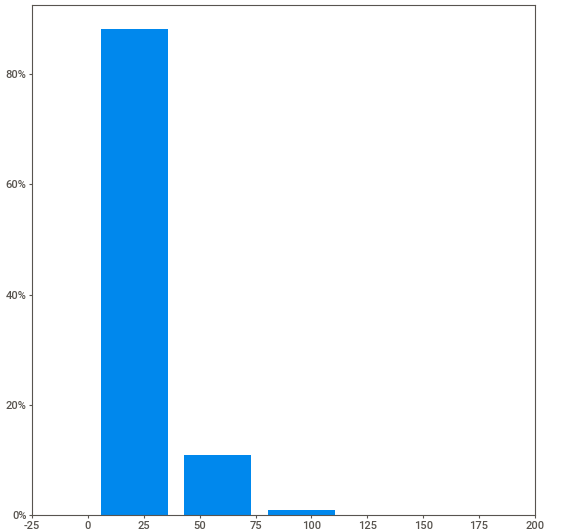
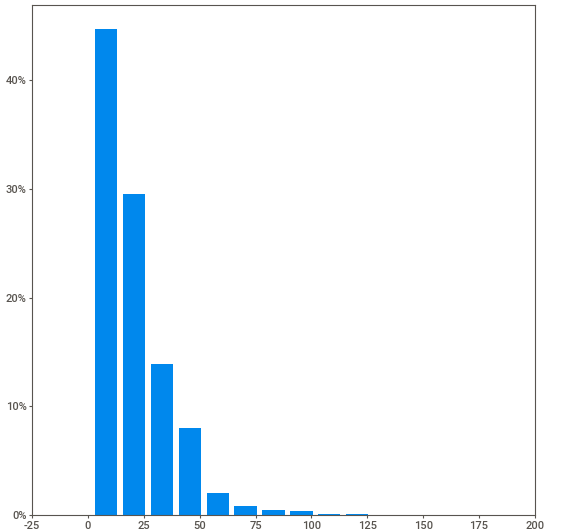
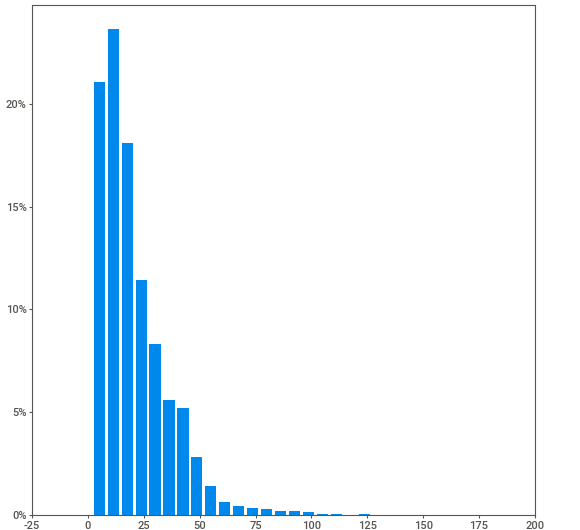
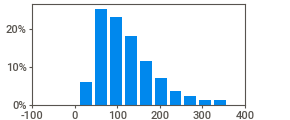
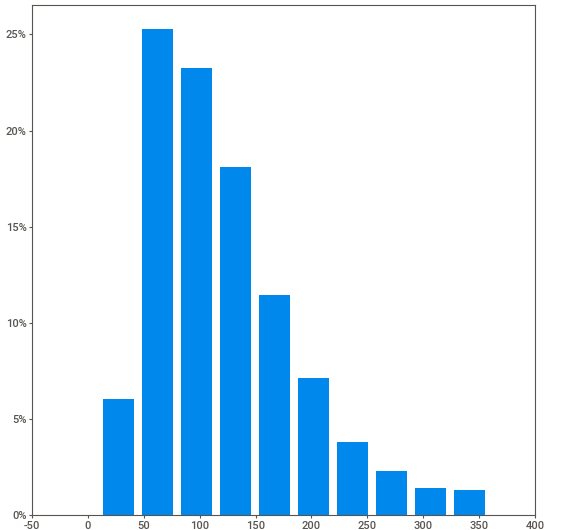
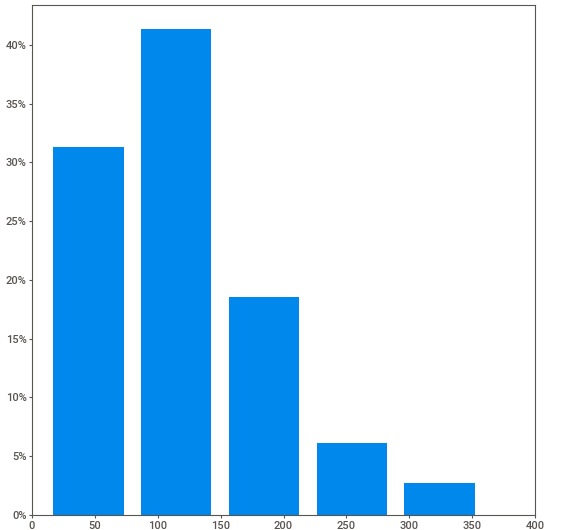
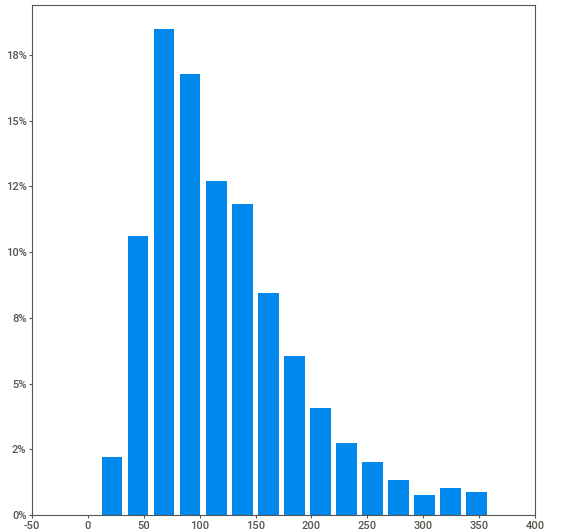
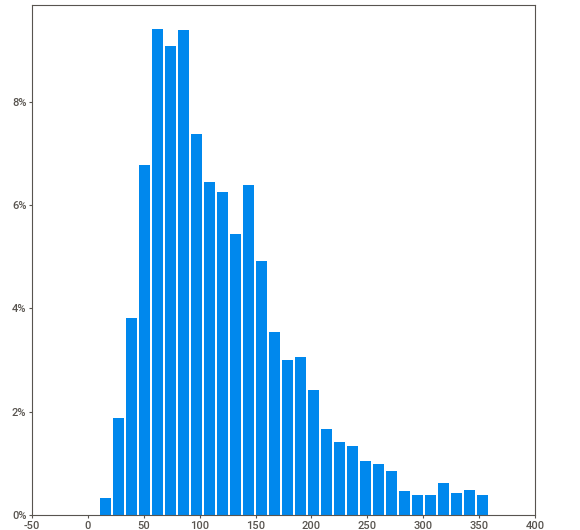
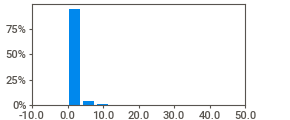
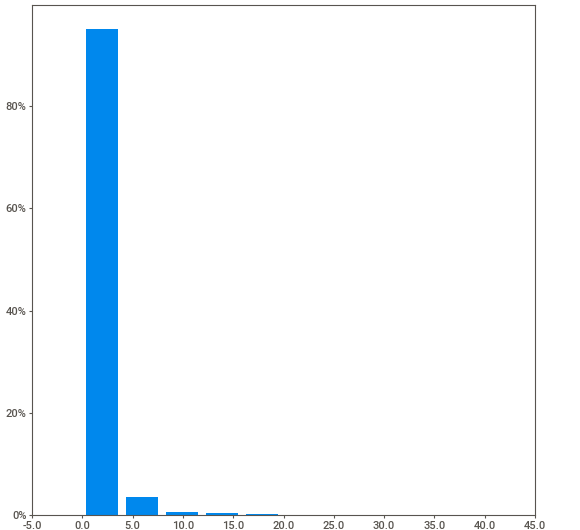
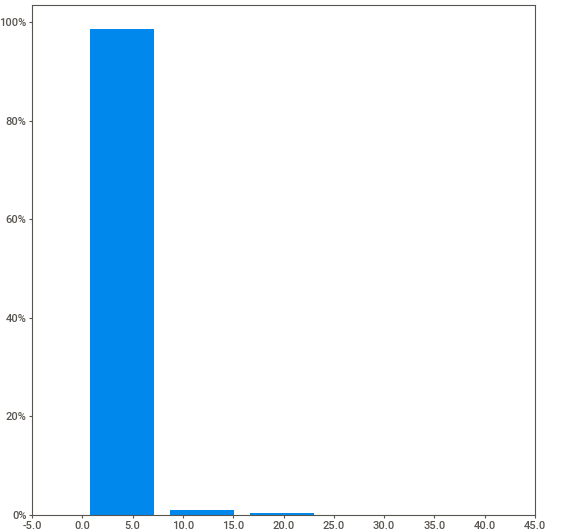
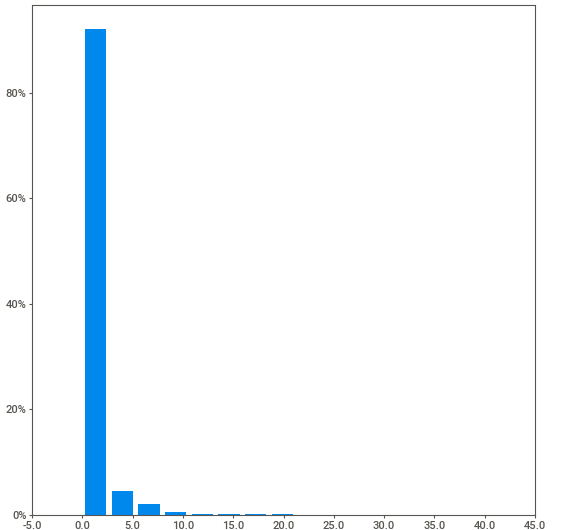
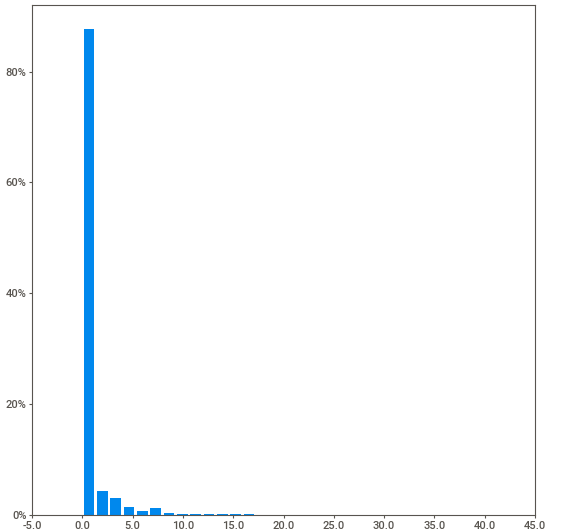
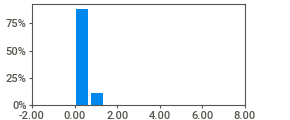
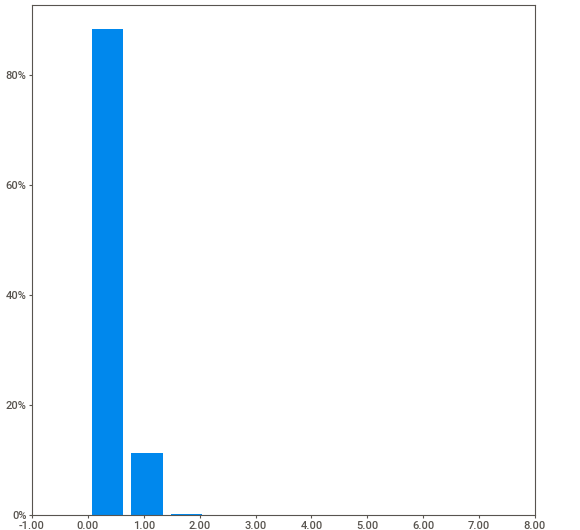
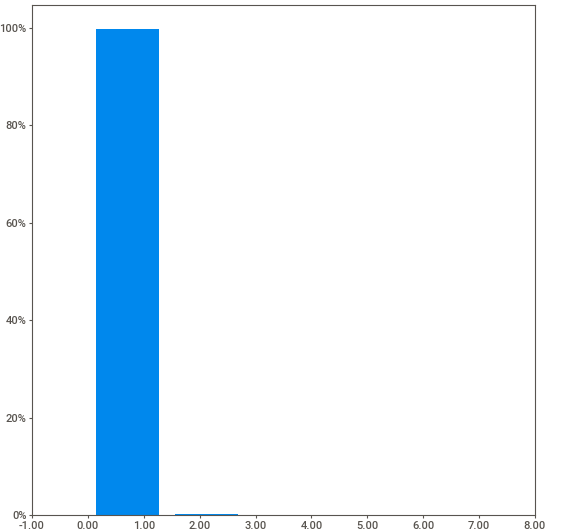
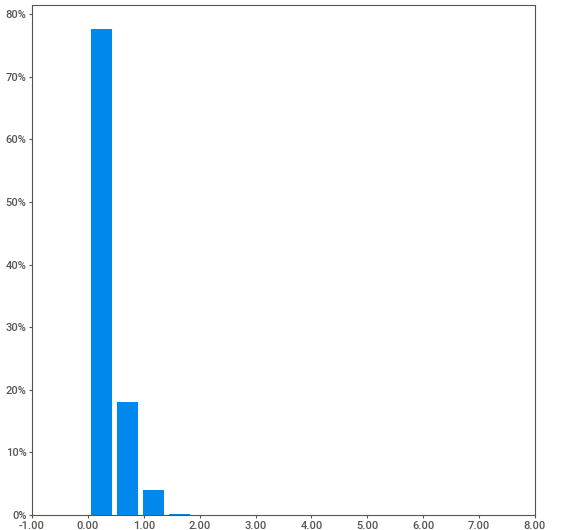
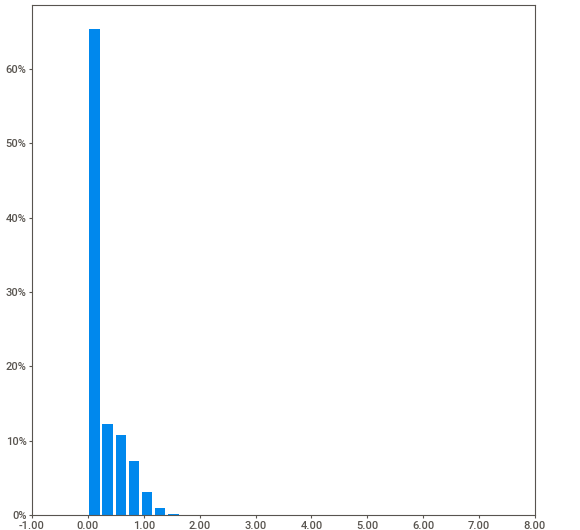
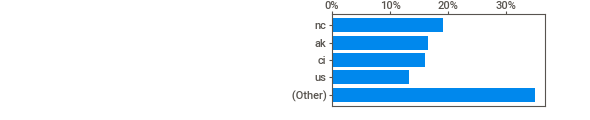
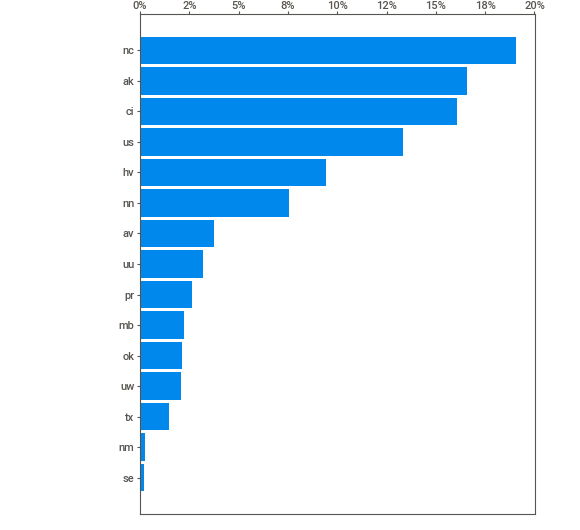
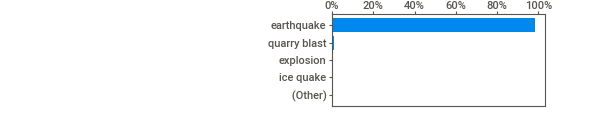
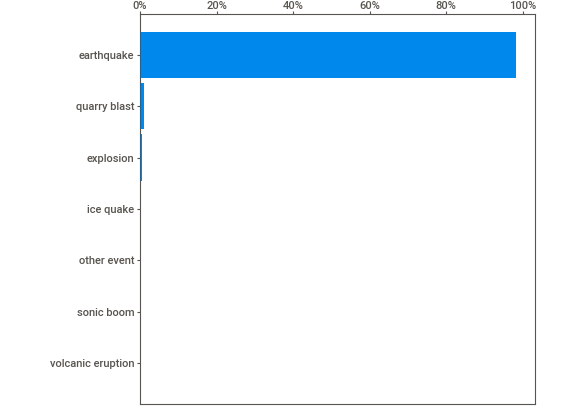
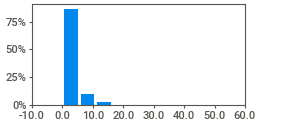
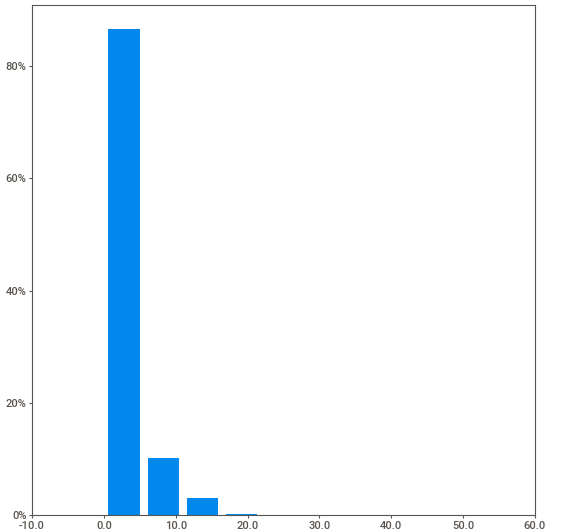
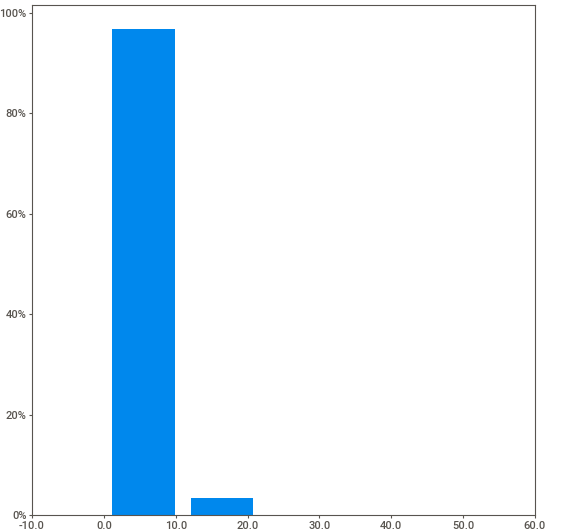
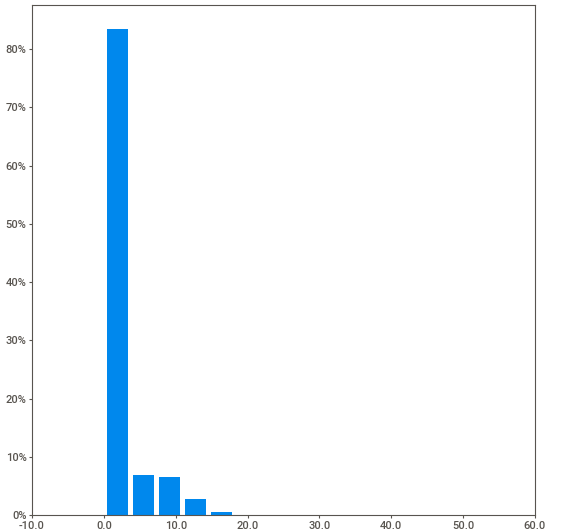
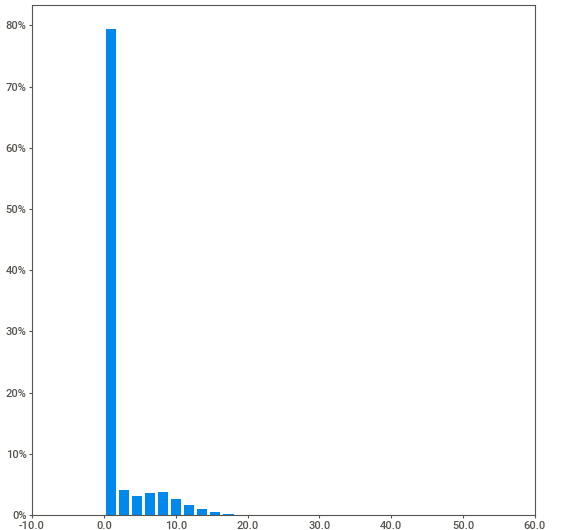
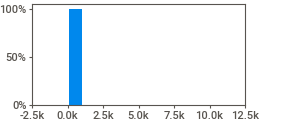
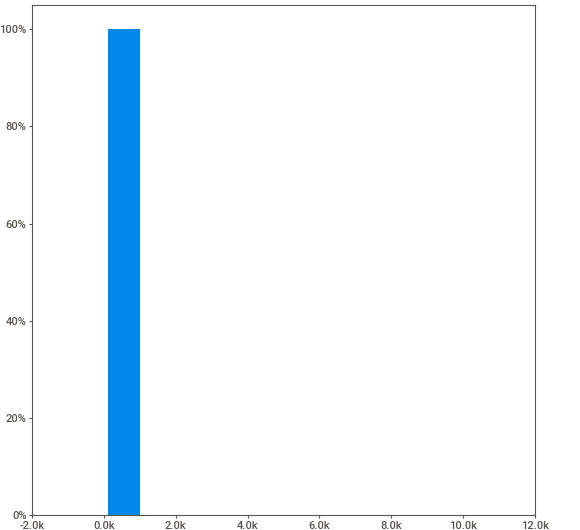
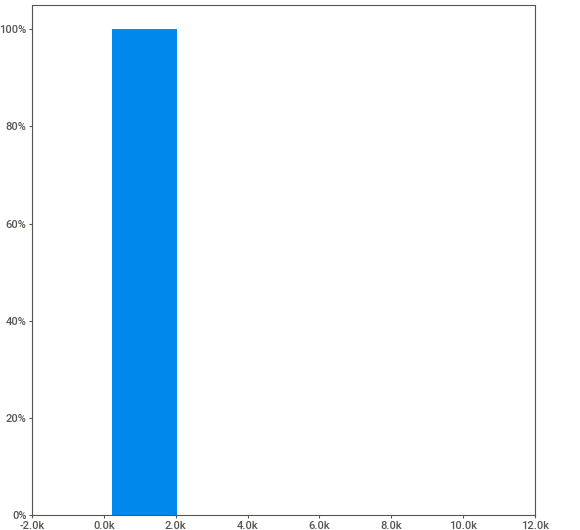
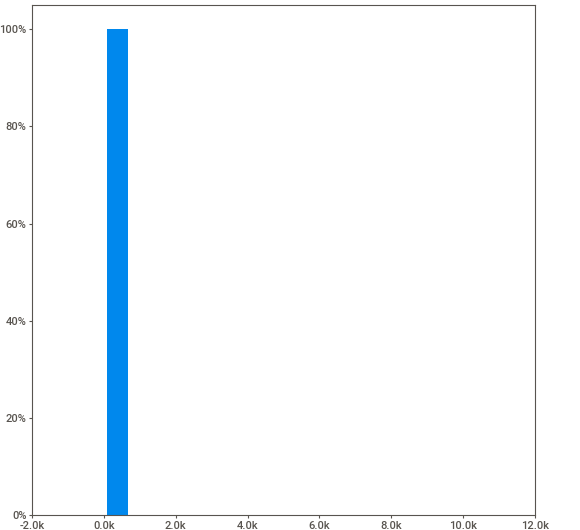
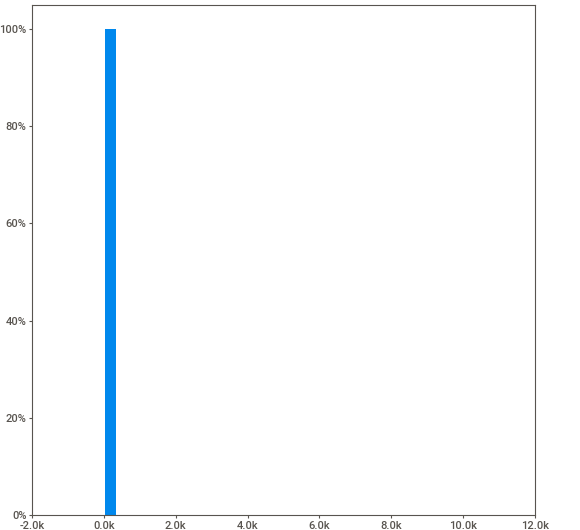
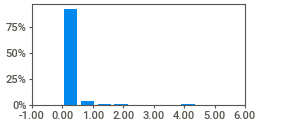
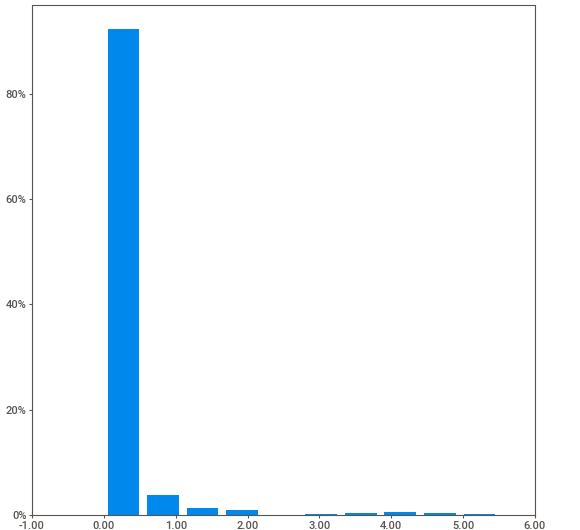
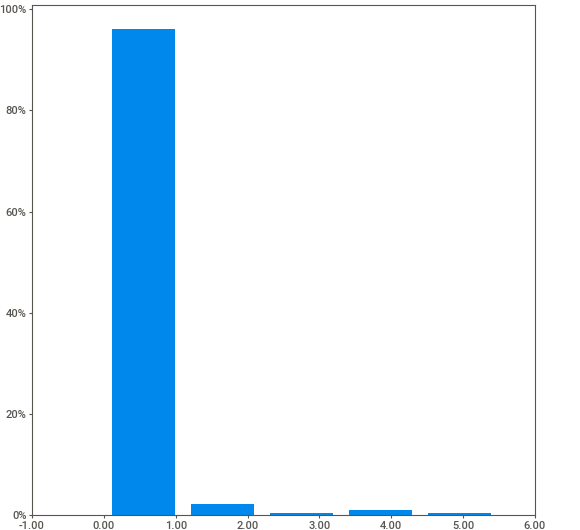
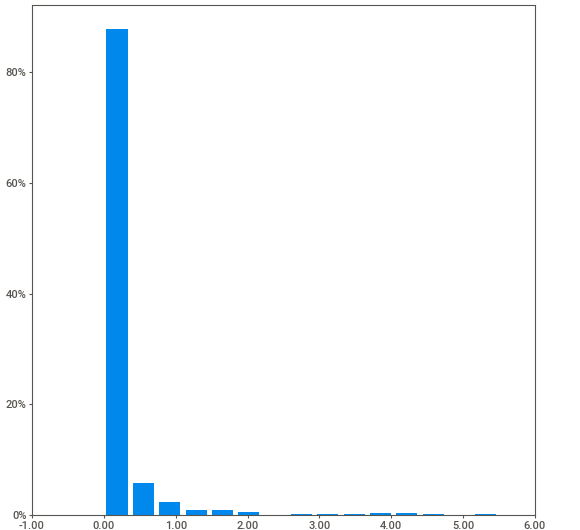
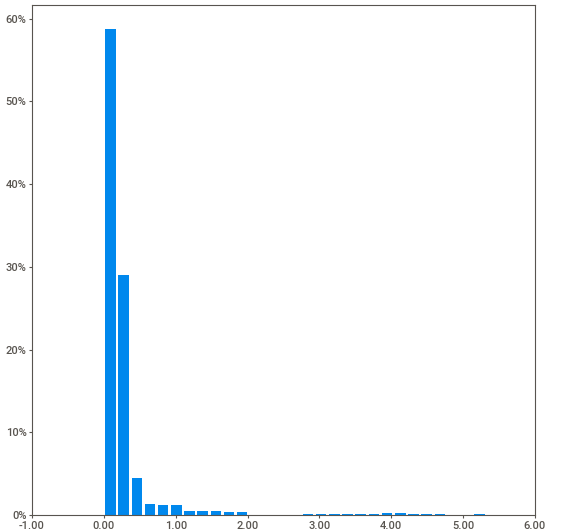
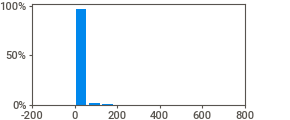
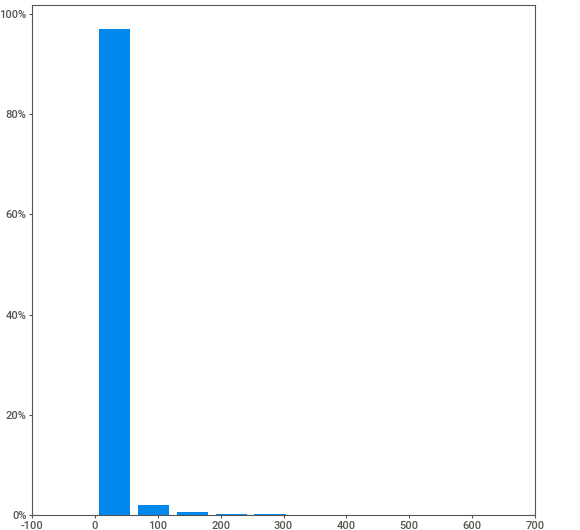
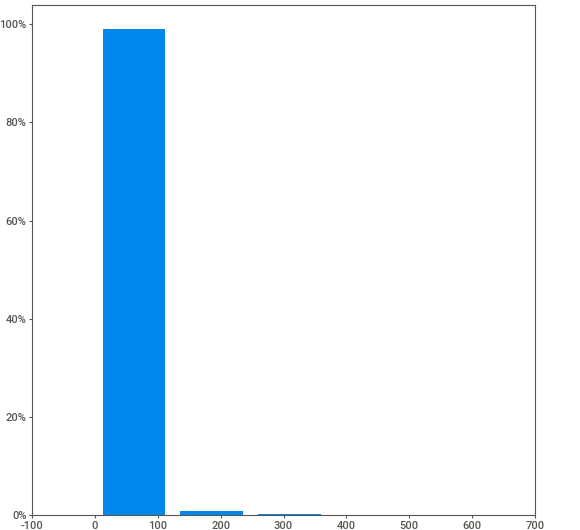
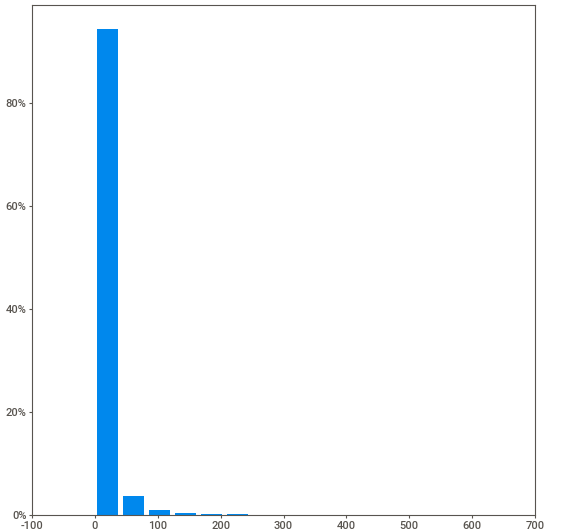
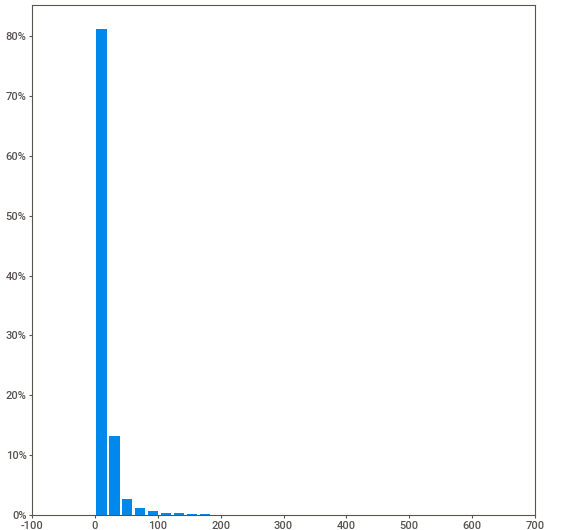
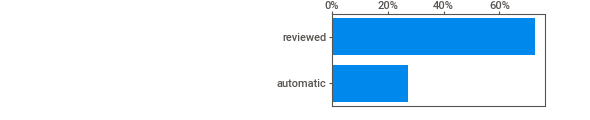
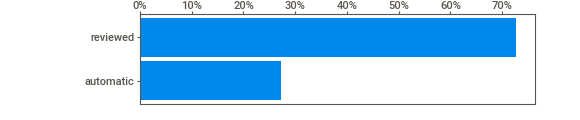
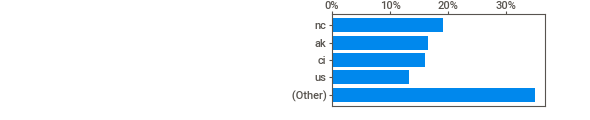
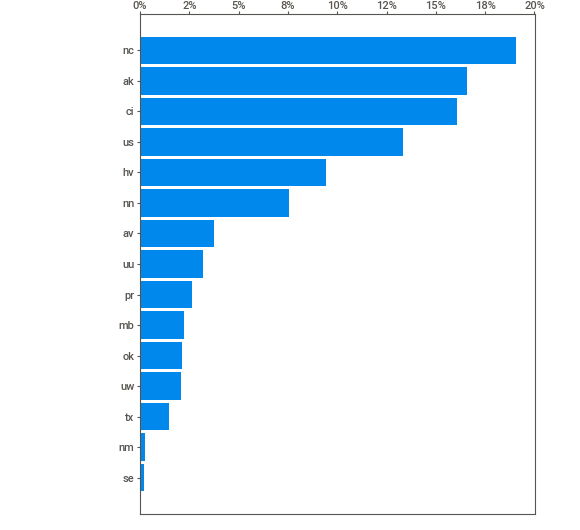
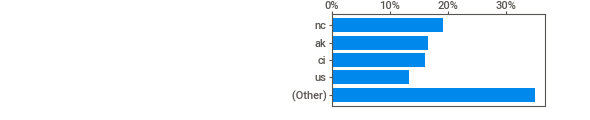
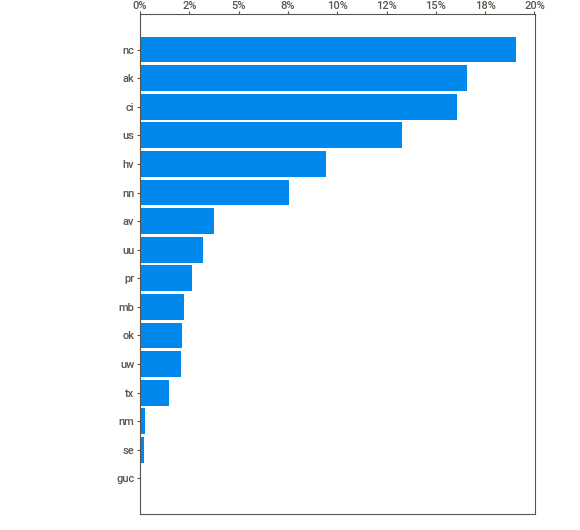
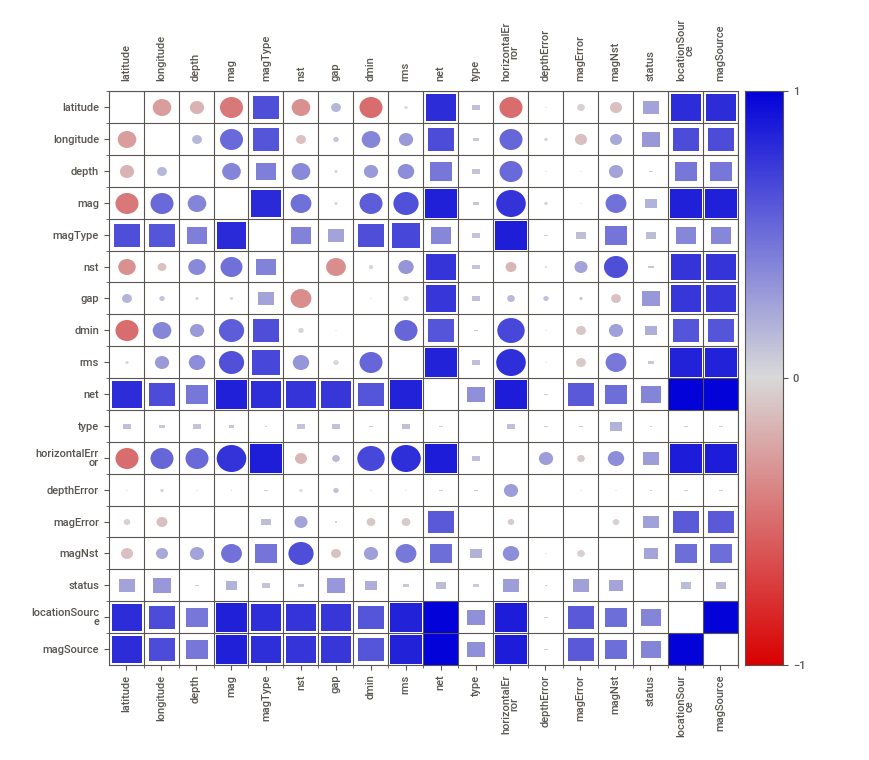
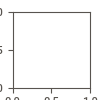

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [14]:
import sweetviz as sv

report_equake = sv.analyze(raw_data)

report_equake.show_notebook(  w=None, 
                h=None, 
                scale=None,
                layout='widescreen',
                filepath=None)

report_equake.show_html()

<AxesSubplot:xlabel='mag', ylabel='Count'>

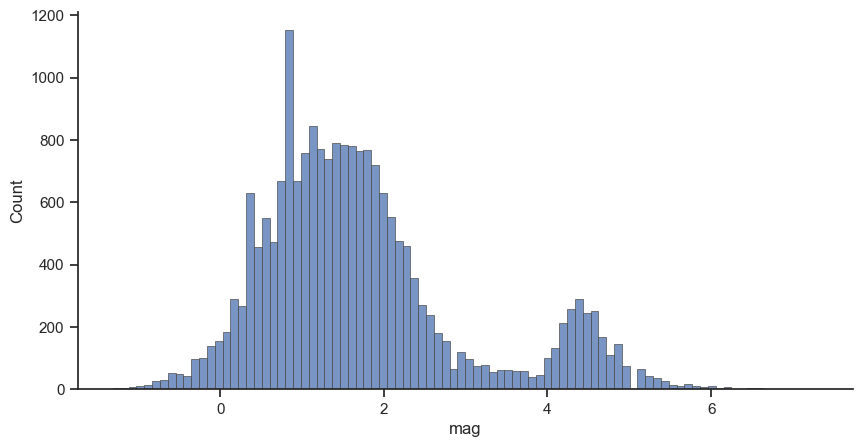

In [15]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# diamonds = sns.load_dataset("diamonds")

f, axs = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot(
    raw_data,
    x="mag",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False
)


<AxesSubplot:xlabel='depth', ylabel='Count'>

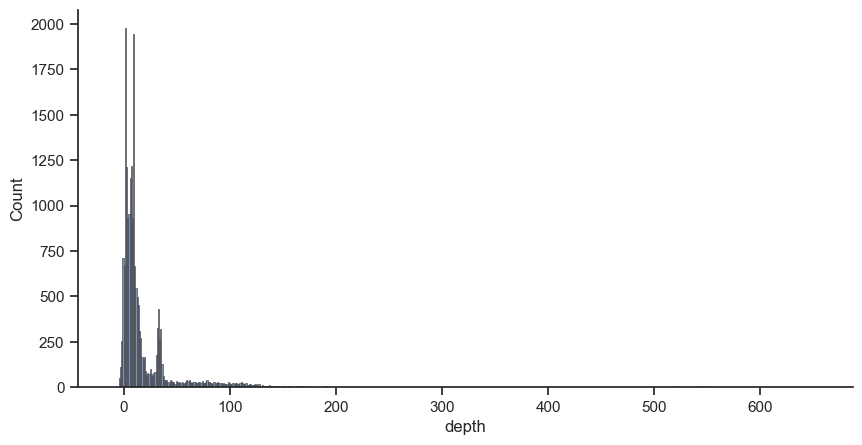

In [16]:
sns.set_theme(style="ticks")

# diamonds = sns.load_dataset("diamonds")

f, axs = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot(
    raw_data,
    x="depth",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False
)

<AxesSubplot:xlabel='latitude', ylabel='Count'>

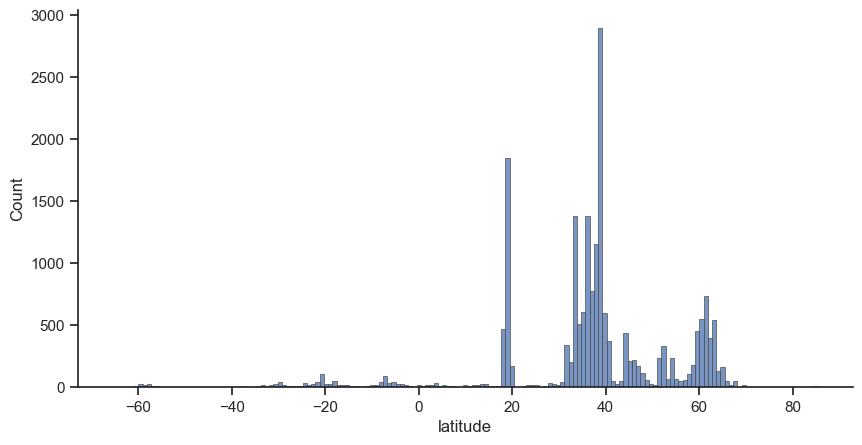

In [17]:
sns.set_theme(style="ticks")

# diamonds = sns.load_dataset("diamonds")

f, axs = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot(
    raw_data,
    x="latitude",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False
)

<AxesSubplot:xlabel='longitude', ylabel='Count'>

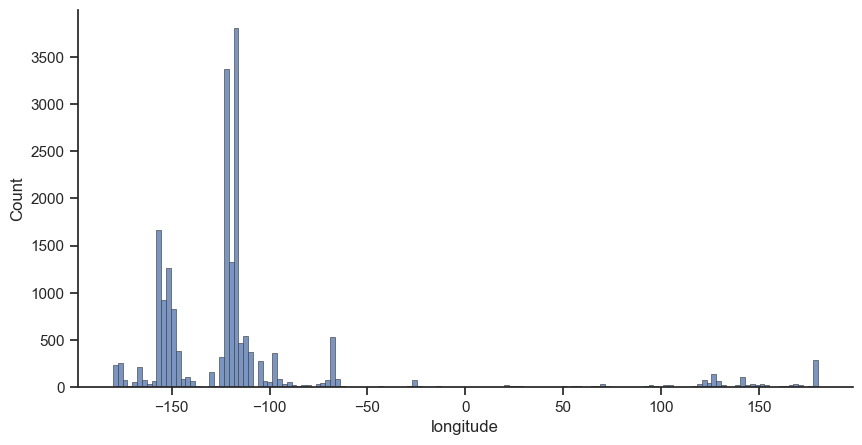

In [18]:
sns.set_theme(style="ticks")

# diamonds = sns.load_dataset("diamonds")

f, axs = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot(
    raw_data,
    x="longitude",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False
)

In [19]:
places_cnt = raw_data['place'].value_counts().to_frame('Count').reset_index()
places_cnt = places_cnt.rename(columns={'index': 'places'})
places_cnt

,places,Count
0,"Rat Islands, Aleutian Islands, Alaska",247
1,"8km NW of The Geysers, CA",236
2,"7km NW of The Geysers, CA",169
3,off the coast of Oregon,158
4,"6km NW of The Geysers, CA",143
...,...,...
9361,"50 km NNW of Sola, Vanuatu",1
9362,"42 km ESE of Barkhan, Pakistan",1
9363,"9 km ESE of Clear, Alaska, Alaska",1
9364,"99 km SW of Atocha, Bolivia",1


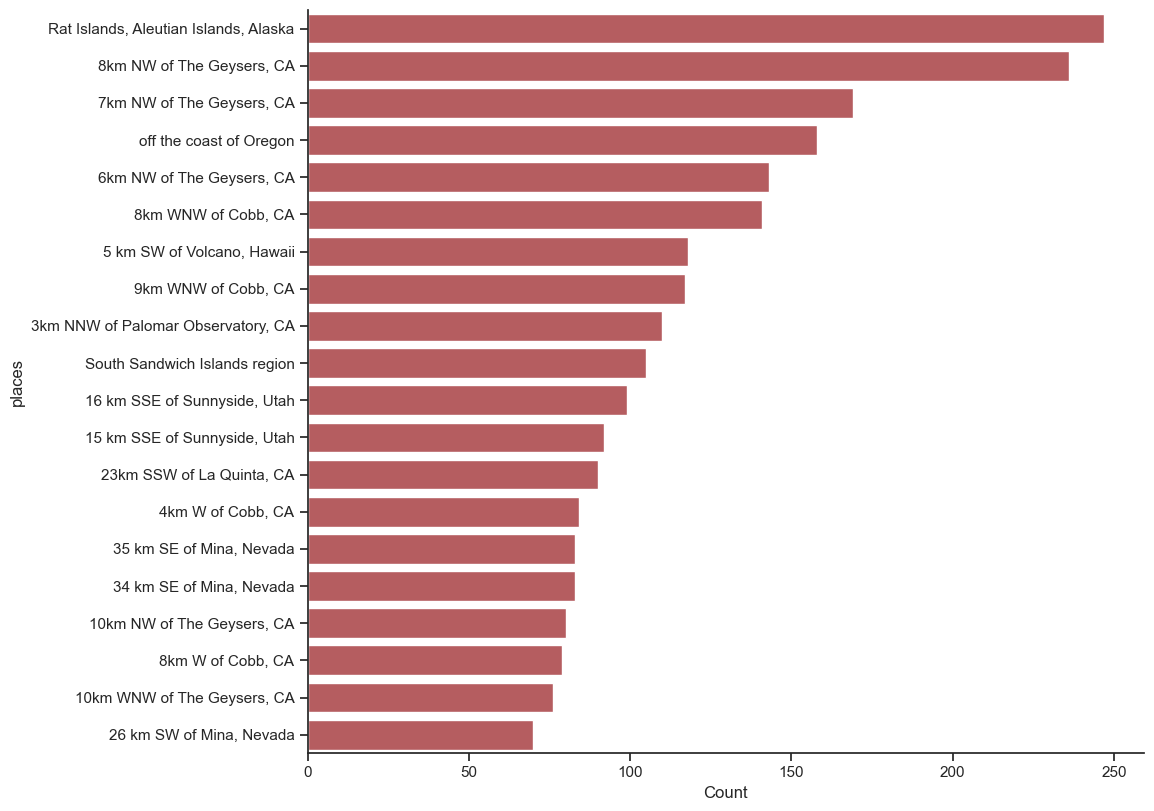

In [20]:
# from matplotlib import rcParams
# rcParams['figure.figsize'] = 11.7,8.27
sns.catplot(y="places", x='Count',data=places_cnt[0:20], kind='bar', color="r", height=8.27, aspect=11.7/8.27)
